In [1]:
import os
import pandas as pd
import numpy as np
from numpy import var, mean, sqrt
import pyfaidx
import pysam
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

In [ ]:
MUT_DATA = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"
TFBS_DATA = "../data/TFBS_data_diff"
REF_FASTA = "../data/ref/hg19.fa"
# JASPAR_NON_REDUNDANT_TF = "../data/datasets/JASPAR2024_CORE_non-redundant_pfms_jaspar.txt"

RESULTS_DIR = "../results/TFBS_diff"

if not os.path.exists(RESULTS_DIR):
	os.makedirs(RESULTS_DIR)

# Fasta sequence extractor
pyfaidx.Faidx(REF_FASTA)
REF_GENOME_OPEN = pysam.Fastafile(REF_FASTA) 

In [3]:
cancer_type = "Skin-Melanoma"

In [ ]:
# with open(JASPAR_NON_REDUNDANT_TF, "r") as jaspar:
# 	jaspar_lines = jaspar.readlines()
# 	jaspar_lines = [line for line in jaspar_lines if line.startswith(">")]
# 	jaspar_lines = [line.split("\t") for line in jaspar_lines]
# 	jaspar_lines = [line[1].strip().upper() for line in jaspar_lines]
# print(f"Number of TFs in JASPAR non-redundant: {len(jaspar_lines)}")
# jaspar_lines[:5]

Number of TFs in JASPAR non-redundant: 2346


['ARNT', 'PAX6', 'RORA', 'RXRA::VDR', 'REL']

In [5]:
mut_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
print(cancer_type, mut_df.shape)
# mutations in driver genes
driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
driver_genes_list = driver_genes["gene"].tolist()
mut_df = mut_df[mut_df["gene"].isin(driver_genes_list)]
print(mut_df.shape)
mut_df = mut_df[["Tumor_Sample_Barcode", "mutation", "gene", "driver", "has_driver", "genic_region"]]
# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)
mut_df.head()

Skin-Melanoma (12450635, 13)
(25121, 13)


,Tumor_Sample_Barcode,mutation,gene,driver,has_driver,genic_region,driver_status
2763,08b5d0e4-4661-460e-a9f7-f2e687414711,1:115250393-115250393:C:T,NRAS,False,False,UTR3,Passengers in absence of driver
2764,08b5d0e4-4661-460e-a9f7-f2e687414711,1:115251285-115251285:G:A,NRAS,False,False,intronic,Passengers in absence of driver
5328,08b5d0e4-4661-460e-a9f7-f2e687414711,1:240936738-240936738:G:A,RGS7,False,False,intergenic,Passengers in absence of driver
5329,08b5d0e4-4661-460e-a9f7-f2e687414711,1:240940982-240940982:T:A,RGS7,False,False,intronic,Passengers in absence of driver
5330,08b5d0e4-4661-460e-a9f7-f2e687414711,1:240978975-240978975:C:T,RGS7,False,False,intronic,Passengers in absence of driver


In [6]:
def get_key(mutation):
	'''
	Generate a key to match the mutation format for TFBS data
	Used to merge the two dataframes on the mutation
	'''
	chrom, pos, ref, alt = mutation.split(":")
	pos = pos.split("-")[0]
	# using 0-based indexing for pysam fetch
	start = int(pos)-1
	end = int(pos)
	# include the previous base in case of indels and MNVs
	if ref == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		pos = int(pos) - 1
	elif alt == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		pos = int(pos) - 1
	elif len(ref) > 1 or len(alt) > 1:
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start) + alt
		pos = int(pos) - 1
	key = f"chr{chrom}:{pos}{ref}>{alt}"
	return key

# add variant column to use as key for TFBS data
mut_df["variant"] = mut_df["mutation"].apply(get_key)
mut_df.head()


,Tumor_Sample_Barcode,mutation,gene,driver,has_driver,genic_region,driver_status,variant
2763,08b5d0e4-4661-460e-a9f7-f2e687414711,1:115250393-115250393:C:T,NRAS,False,False,UTR3,Passengers in absence of driver,chr1:115250393C>T
2764,08b5d0e4-4661-460e-a9f7-f2e687414711,1:115251285-115251285:G:A,NRAS,False,False,intronic,Passengers in absence of driver,chr1:115251285G>A
5328,08b5d0e4-4661-460e-a9f7-f2e687414711,1:240936738-240936738:G:A,RGS7,False,False,intergenic,Passengers in absence of driver,chr1:240936738G>A
5329,08b5d0e4-4661-460e-a9f7-f2e687414711,1:240940982-240940982:T:A,RGS7,False,False,intronic,Passengers in absence of driver,chr1:240940982T>A
5330,08b5d0e4-4661-460e-a9f7-f2e687414711,1:240978975-240978975:C:T,RGS7,False,False,intronic,Passengers in absence of driver,chr1:240978975C>T


In [7]:
# TFBS data
tfbs_df = pd.read_csv(f"{TFBS_DATA}/{cancer_type}.tsv", sep="\t")
tfbs_df["variant_tf"] = tfbs_df.apply(lambda x: f"{x['variant']}_{x['tf']}", axis=1)
tfbs_var_dict = tfbs_df.set_index("variant_tf")["score"].to_dict()
tfbs_df.head()

,variant,tf,score,variant_tf
0,chr10:96793531G>A,A1CF,0.0255,chr10:96793531G>A_A1CF
1,chr10:96793531G>A,ABCF2,0.0109,chr10:96793531G>A_ABCF2
2,chr10:96793531G>A,ADARB1,0.5498,chr10:96793531G>A_ADARB1
3,chr10:96793531G>A,AGAP2,0.0783,chr10:96793531G>A_AGAP2
4,chr10:96793531G>A,AGGF1,-0.0448,chr10:96793531G>A_AGGF1


In [8]:
mut_tf_df = mut_df[["Tumor_Sample_Barcode", "variant", "gene", "driver_status", "genic_region"]].copy()
mut_tf_df = mut_tf_df[mut_tf_df["genic_region"] == "upstream"]
print(mut_tf_df.shape)
mut_tf_df.drop_duplicates(inplace=True)
print(mut_tf_df.shape)
mut_tf_df.head()

(91, 5)
(91, 5)


,Tumor_Sample_Barcode,variant,gene,driver_status,genic_region
49242,08b5d0e4-4661-460e-a9f7-f2e687414711,chr5:1295250G>A,TERT,Drivers,upstream
216166,0ab4d782-9a50-48b9-96e4-6ce42b2ea034,chr5:1295250G>A,TERT,Drivers,upstream
216167,0ab4d782-9a50-48b9-96e4-6ce42b2ea034,chr5:1295283G>A,TERT,Drivers,upstream
362871,108749d2-5c62-4ef1-92df-aec6941ba53b,chr5:1295205G>A,TERT,Drivers,upstream
490305,13c62975-9f5e-4d40-a461-dceab08a31ec,chr5:1295228G>A,TERT,Drivers,upstream


In [9]:
def cohen_d(x, y):
    # size of samples
    n1, n2 = len(x), len(y)
    # variance of the samples
    s1, s2 = var(x, ddof=1), var(y, ddof=1)
    # pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # means of the samples
    u1, u2 = mean(x), mean(y)
    # return the effect size
    return (u1 - u2) / s

In [10]:
tf_diff = []
tfs = tfbs_df["tf"].unique().tolist()
mut_tf_data = pd.DataFrame()
for tf in tfs:
	mut_data_df = mut_tf_df.copy()
	mut_data_df["tf"] = tf
	mut_data_df["score"] = mut_data_df.apply(lambda x: tfbs_var_dict.get(f"{x['variant']}_{tf}", 0), axis=1).astype(float)
	mut_data_df["abs_score"] = mut_data_df["score"].abs()
	mut_data_df["prediction"] = mut_data_df["score"].apply(lambda x: "gain" if x > 0 else "loss")
	mut_data_df["prediction"] = mut_data_df["prediction"].apply(lambda x: "no change" if x == 0 else x)
	mut_tf_data = pd.concat([mut_tf_data, mut_data_df], axis=0)
mut_tf_data.reset_index(drop=True, inplace=True)
print(mut_tf_data.shape)
mut_tf_data.head()

(126217, 9)


,Tumor_Sample_Barcode,variant,gene,driver_status,genic_region,tf,score,abs_score,prediction
0,08b5d0e4-4661-460e-a9f7-f2e687414711,chr5:1295250G>A,TERT,Drivers,upstream,A1CF,0.0,0.0,loss
1,0ab4d782-9a50-48b9-96e4-6ce42b2ea034,chr5:1295250G>A,TERT,Drivers,upstream,A1CF,0.0,0.0,loss
2,0ab4d782-9a50-48b9-96e4-6ce42b2ea034,chr5:1295283G>A,TERT,Drivers,upstream,A1CF,0.0,0.0,loss
3,108749d2-5c62-4ef1-92df-aec6941ba53b,chr5:1295205G>A,TERT,Drivers,upstream,A1CF,0.0,0.0,loss
4,13c62975-9f5e-4d40-a461-dceab08a31ec,chr5:1295228G>A,TERT,Drivers,upstream,A1CF,0.0,0.0,loss


In [11]:
# gene = "FBXW7"
# plot_data = mut_tf_data[mut_tf_data["gene"] == gene]
plot_data = mut_tf_data[mut_tf_data["driver_status"] != "Drivers"]
plot_data

,Tumor_Sample_Barcode,variant,gene,driver_status,genic_region,tf,score,abs_score,prediction
7,22d67778-61fc-4f15-95b8-7e7c6cc7112b,chr10:96830190G>A,CYP2C8,Passengers in absence of driver,upstream,A1CF,0.0000,0.0000,loss
8,22d67778-61fc-4f15-95b8-7e7c6cc7112b,chr17:48279225G>A,COL1A1,Passengers in absence of driver,upstream,A1CF,0.0235,0.0235,gain
9,25103371-28ac-4f43-b0e2-2d376d0dcb84,chr10:96829300G>A,CYP2C8,Passengers in absence of driver,upstream,A1CF,0.2707,0.2707,gain
10,25103371-28ac-4f43-b0e2-2d376d0dcb84,chr10:96830028C>T,CYP2C8,Passengers in absence of driver,upstream,A1CF,0.0000,0.0000,loss
12,2790b964-63e3-49aa-bf8c-9a00d3448c25,chr7:98475319C>T,TRRAP,Passengers in absence of driver,upstream,A1CF,0.0121,0.0121,gain
...,...,...,...,...,...,...,...,...,...
126200,978ae91e-6ebe-4efa-97ff-cfad511ae7b3,chr12:46123258G>A,ARID2,Passengers in absence of driver,upstream,UGP2,0.0000,0.0000,loss
126201,978ae91e-6ebe-4efa-97ff-cfad511ae7b3,chr12:46123395C>T,ARID2,Passengers in absence of driver,upstream,UGP2,-0.3715,0.3715,loss
126205,b07bad52-d44c-4b27-900a-960985bfadec,chr3:77088443C>T,ROBO2,Passengers in absence of driver,upstream,UGP2,-0.0381,0.0381,loss
126206,b07bad52-d44c-4b27-900a-960985bfadec,chr3:169382259A>G,MECOM,Passengers in absence of driver,upstream,UGP2,0.7061,0.7061,gain


In [12]:
# Group by TF and condition to get list of scores
grouped = plot_data.groupby(['tf', 'driver_status'])['abs_score'].apply(list).unstack()

# Compute statistics
results = []
for tf in grouped.index:
    group1 = grouped.loc[tf, 'Passengers in absence of driver']
    group2 = grouped.loc[tf, 'Passengers in presence of driver']
    stat, pval = ttest_ind(group1, group2, equal_var=False)
    diff = np.mean(group1) - np.mean(group2)
    results.append({'tf': tf, 'p_val': pval, 'diff': diff})
    
volcano_df = pd.DataFrame(results)
volcano_df.dropna(inplace=True) 
volcano_df["log_p"] = volcano_df["p_val"].apply(lambda x: -np.log10(x))
# multiple testing correction
rejected, pvals_corrected, _, _ = multipletests(volcano_df['p_val'], method='fdr_bh')
volcano_df['pval_adj'] = pvals_corrected
volcano_df["log_p_adj"] = volcano_df["pval_adj"].apply(lambda x: -np.log10(x))
volcano_df

,tf,p_val,diff,log_p,pval_adj,log_p_adj
0,A1CF,0.656296,-0.057293,0.182900,0.873944,0.058516
1,ABCF2,0.492630,-0.075021,0.307479,0.842513,0.074423
2,ACO1,0.005837,0.045284,2.233826,0.078598,1.104587
3,ADARB1,0.001096,0.090184,2.960185,0.037949,1.420796
4,AFF4,0.473486,-0.100504,0.324693,0.832352,0.079693
...,...,...,...,...,...,...
1382,ZSCAN29,0.224137,0.027575,0.649487,0.584341,0.233334
1383,ZSCAN31,0.504779,0.011407,0.296899,0.845811,0.072727
1384,ZSCAN4,0.710705,0.004835,0.148311,0.893246,0.049029
1385,ZSCAN9,0.853309,0.021694,0.068894,0.939541,0.027084


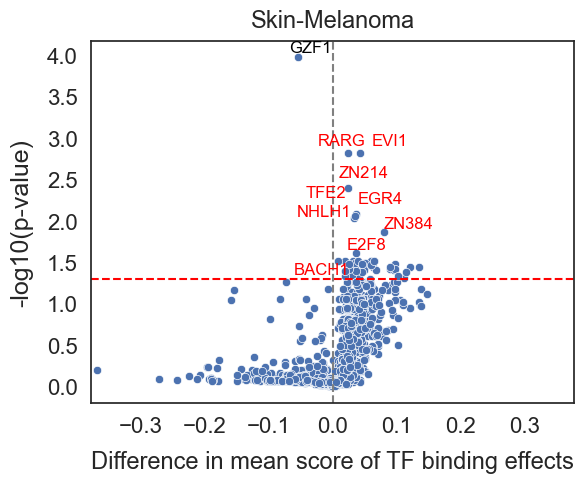

In [ ]:
plt.figure(figsize=(6, 5))
sns.set(style="white")
sns.scatterplot(
    data=volcano_df, 
    x='diff', 
    y='log_p_adj'
)
plt.axhline(-np.log10(0.05), color='red', linestyle='--')  # p = 0.05 cutoff
plt.axvline(0, color='gray', linestyle='--')  # no difference cutoff

# center x axis at 0
max_abs = max(abs(volcano_df["diff"].min()), abs(volcano_df["diff"].max()))
max_abs += 0.01
plt.xlim(-max_abs, max_abs)

# annotate passenger mutations that cause big splicing changes (>= 50% change in probablity)
# avoid overlapping text
annot = []
top_tfs = volcano_df.nlargest(10, 'log_p_adj')["tf"].tolist() # get top 10 TFs by significance
for index, row in volcano_df.iterrows():
	if row["log_p_adj"] > -np.log10(0.05) and row["diff"] > 0 and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='red'))
	elif row["log_p_adj"] > -np.log10(0.05) and row["diff"] < 0 and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='black'))
adjust_text(annot)

plt.xticks(fontsize=16)
plt.xlabel('Difference in mean score of TF binding effects', fontsize=17, labelpad=10)
plt.yticks(fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=18, labelpad=10)
# plt.title(f"TF binding changes caused by\n{gene} mutations in {cancer_type}", fontsize=17, pad=10)
plt.title(cancer_type, fontsize=17, pad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/{cancer_type}_TFBS_diff.png", dpi=300)